In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qurveros import misctools
from qurveros.settings import settings

import matplotlib
from matplotlib import cycler

import qurveros.plot_configs
matplotlib.rcParams['figure.dpi'] = 150
import td_analysis_helper
import filter_functions

In [2]:
def gate_filter_cond(name):
    
    if ('xgate' or 'hadamard' in name) and 'step50000' in name:
        return True

In [3]:
control_points_paths = [os.path.join(os.getcwd(),'control_points', name) 
                        for name in os.listdir('control_points') 
                        if gate_filter_cond(name)]

sim_data_paths = [os.path.join(os.getcwd(),'sims', name) 
                  for name in os.listdir('sims') 
                  if 'log' not in  name]

gate_dict = {}

for filepath in control_points_paths:
    gate_key = os.path.basename(filepath).rstrip('.csv')
    curve = misctools.prepare_bezier_from_file(filepath, is_barq=True)
    curve.evaluate_control_dict('TTC')
    gate_dict[gate_key] = curve   

In [4]:
sim_data_paths = sorted(sim_data_paths, reverse=True)[:4] #use the most recent sims

In [5]:
sim_data_paths

['/home/evpiliouras_local/qurveros_dev/qurveros_before_launch/results/sims/20250131_134915_hadamard_step50000_noise_2.csv',
 '/home/evpiliouras_local/qurveros_dev/qurveros_before_launch/results/sims/20250130_153358_hadamard_step50000_noise_1.csv',
 '/home/evpiliouras_local/qurveros_dev/qurveros_before_launch/results/sims/20250129_135655_xgate_step50000_noise_1.csv',
 '/home/evpiliouras_local/qurveros_dev/qurveros_before_launch/results/sims/20250129_050726_xgate_step50000_noise_2.csv']

In [6]:
gate_dict

{'hadamard_step50000': <qurveros.spacecurve.BezierCurve at 0x7fc33a6aa6f0>,
 'xgate_step50000': <qurveros.spacecurve.BezierCurve at 0x7fc339b9baa0>}

In [7]:
plot_dict = dict()

In [8]:
plot_dict['hadamard_step50000'] = dict(
    ff_color = "#F5720A",
)
plot_dict['xgate_step50000'] = dict(
    ff_color = "#8CB709",
)

In [9]:
for key in plot_dict:

    control_dict = gate_dict[key].get_control_dict()

    omega_tau, ff, ps = td_analysis_helper.get_dephasing_ff_ps(
                                            control_dict, 
                                            n_samples=2000,
                                            omega_tau_max = 12*np.pi)
    
    plot_dict[key]['omega_tau'] = omega_tau
    plot_dict[key]['filter_function'] = ff
    plot_dict[key]['pulse_sequence'] = ps

In [10]:
width = plt.rcParams['figure.figsize'][0]
height = plt.rcParams['figure.figsize'][1]

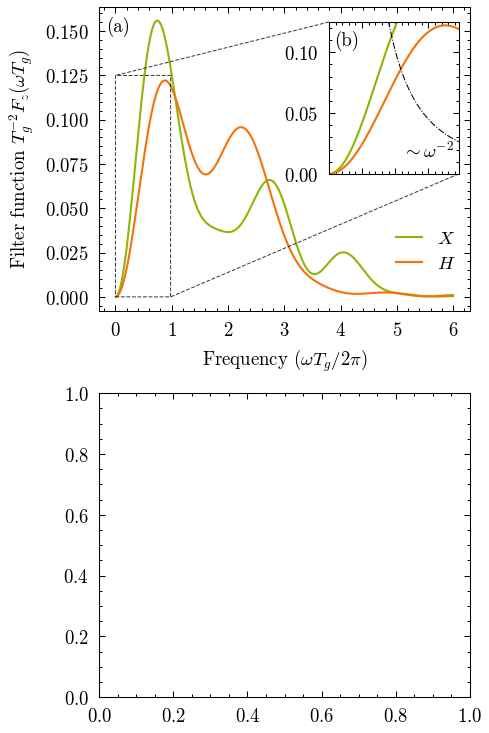

In [11]:
fig, axs = plt.subplots(2,1,layout='constrained', figsize = (width, 2*height))

filter_fun_ax = axs[0]
inset_ax = filter_fun_ax.inset_axes([0.62,0.45,0.35,0.5])

time_dep_ax = axs[1]

for key in sorted(plot_dict.keys(), reverse=True):
    
    for ax in [filter_fun_ax, inset_ax]:
        
        ax.plot(plot_dict[key]['omega_tau']/(2*np.pi),
                plot_dict[key]['filter_function'].real,
                color = plot_dict[key]['ff_color'],
                label = f'${key[0].upper()}$')
    
inset_ax.plot(omega_tau/(2*np.pi), 
              1/((omega_tau))**2,'k', 
              linewidth = 0.5,
              linestyle = '-.')

inset_ax.set_xlim([0,0.98])
inset_ax.set_ylim([0,0.125])

inset_ax.text(0.56,0.11,r'$\sim\omega^{-2}$',
               fontsize = matplotlib.rcParams['axes.labelsize'],
               transform=inset_ax.transAxes)


filter_fun_ax.text(0.02,0.92,'(a)',
               fontsize = matplotlib.rcParams['axes.labelsize'],
               transform=filter_fun_ax.transAxes)

inset_ax.text(0.04,0.85,'(b)',
               fontsize = matplotlib.rcParams['axes.labelsize'],
               transform=inset_ax.transAxes)

filter_fun_ax.set_xlabel(r'Frequency $(\omega T_g/2\pi)$')
filter_fun_ax.set_ylabel(r'Filter function $T_g^{-2}F_{z}(\omega T_g)$')
filter_fun_ax.locator_params(axis='x', nbins=10)

inset_ax.locator_params(axis='x', nbins=4)
inset_ax.locator_params(axis='y', nbins=3)
inset_ax.set_xticklabels([])

filter_fun_ax.legend(loc=[0.78,0.1])
filter_fun_ax.indicate_inset_zoom(inset_ax, 
                                  edgecolor='k',
                                  linestyle = '--',
                                  alpha=0.75,
                                  linewidth=0.5)

In [12]:
# For plots
color_palette = ['#17becf', '#7f7f7f', '#d62728', '#8c564b']
color_idx = -1
for gate in plot_dict:
    for alpha in [1, 2]:
        color_idx += 1
        plot_dict[gate][f'noise_{alpha}'] = {}

        for result_type in ['simulated', 'analytic']:
            
            if result_type == 'simulated':
                linewidth = 0
                markersize = 0.5*matplotlib.rcParams['lines.markersize']
                
                if 'xgate' in gate:
                    marker = 'x'
                    zorder = 2
                else:
                    marker = '.'
                    zorder = 1
                
                if 'hadamard' in gate and alpha == 1:
                    zorder = 2
       
            else:
                linewidth = 0.75*matplotlib.rcParams['lines.linewidth']
                markersize = 0
                marker =  None
                zorder = 0
                
            plot_dict[gate][f'noise_{alpha}'][result_type] = {
                'plot_args': {
                        'label' : rf'${gate[0].upper()}(\alpha={alpha})$',
                        'linewidth' : linewidth,
                        'markersize': markersize,
                        'marker': marker,
                        'zorder' : zorder,
                        'color': color_palette[color_idx],
                        'fillstyle': 'none'}                     
                }

In [13]:
# For analytic results
d=2
for gate in plot_dict:

    curve = gate_dict[gate]
    curve.evaluate_robustness_properties()
    ps = plot_dict[gate]['pulse_sequence']

    Tg = curve.get_control_dict()['times'][-1]

    omega = filter_functions.util.get_sample_frequencies(ps,
                                                     n_samples= 2048,
                                                     spacing='linear',
                                                     omega_min = (1e-3)*2*np.pi/Tg,
                                                     omega_max = 50*2*np.pi/Tg)

    for alpha in [1, 2]:

        omega_b = (2*np.pi)/Tg
        spectrum = Tg/((omega/omega_b)**alpha) # ps is calculated for Tg*delta_z=1
        
        K = filter_functions.numeric.calculate_cumulant_function(ps, 
                                                     #For two-sided PSD
                                                     spectrum = 2*spectrum, 
                                                     omega = omega)[0]
        
        infid = -K.trace()/(d*(d+1)) # d*(d+1) factor from average gate fidelity
        plot_dict[gate][f'noise_{alpha}']['analytic']['infidelity'] =  infid

        if alpha == 2:
            cfi = curve.get_robustness_properties().robustness_dict['CFI']
            cfi_infid = (((Tg*omega_b)**2)/(2*(d+1)))*cfi
            plot_dict[gate][f'noise_{alpha}']['analytic']['infidelity_cfi'] = cfi_infid

In [14]:
# Simulated data load
for data_sim_path in sim_data_paths:
    sim_filename = os.path.basename(data_sim_path).rstrip('.csv')
    filename_split = sim_filename.split('_')
    
    gate = filename_split[2] + '_' + filename_split[3]
    alpha = int(filename_split[-1])
    
    data = pd.read_csv(data_sim_path).to_numpy()

    plot_dict[gate][f'noise_{alpha}']['simulated']['data'] = data
    plot_dict[gate][f'noise_{alpha}']['simulated']['tg_delta_z'] = data[0]
    plot_dict[gate][f'noise_{alpha}']['analytic']['tg_delta_z'] = data[0]
    
    nan_list = np.argwhere(np.isnan(data[1:]))
    if len(nan_list) > 0:
        print(f'{data_sim_path}: {nan_list}')
    plot_dict[gate][f'noise_{alpha}']['simulated']['infidelity'] = np.nanmean(data[1:], axis=0)
    print(data[1:].shape)

(10000, 12)
(10000, 12)
(10000, 12)
(10000, 12)


In [15]:
# Plot
legend_dict = {
    'simulated':[],
    'analytic':[]
}

infid_dict = {}

for gate in sorted(plot_dict.keys(), reverse=True):
    infid_dict[gate] = {}
    for alpha in [1, 2]:
        infid_dict[gate][alpha] = {}
        for result_type in plot_dict[gate][f'noise_{alpha}']:

            tg_delta_z_log = np.log10(
                plot_dict[gate][f'noise_{alpha}'][result_type]['tg_delta_z'])

            if result_type == 'simulated':
                infid_log_for_plot = np.log10(
                
                plot_dict[gate][f'noise_{alpha}']['simulated']['infidelity'])
                infid_dict[gate][alpha][result_type] = \
                plot_dict[gate][f'noise_{alpha}']['simulated']['infidelity'][-1]
                
            else:
                infid_log_for_plot = 2*tg_delta_z_log +\
                    np.log10(plot_dict[gate][f'noise_{alpha}']['analytic']['infidelity'])
                
                infid_dict[gate][alpha][result_type] =\
                plot_dict[gate][f'noise_{alpha}']['analytic']['infidelity']
                
                if alpha == 2:
                    infid_dict[gate][alpha]['cfi'] = \
                    plot_dict[gate][f'noise_{alpha}']['analytic']['infidelity_cfi']
                else:
                    infid_dict[gate][alpha]['cfi'] = np.nan

            line, =  time_dep_ax.plot(tg_delta_z_log, 
                                      infid_log_for_plot,
                    **plot_dict[gate][f'noise_{alpha}'][result_type]['plot_args'])
            
            if result_type=='analytic':
                line.set_dashes([5,4])
            legend_dict[result_type].append(line)

l_simulated = time_dep_ax.legend(
    handles=legend_dict['simulated'], 
    loc='lower right', bbox_to_anchor=(1, 0),
    title = 'Simulated')

l_analytic = time_dep_ax.legend(
    handles = legend_dict['analytic'],
    loc='upper left', bbox_to_anchor=(0, 1),
    title = 'Analytic'
)

fig.add_artist(l_simulated)
fig.add_artist(l_analytic)

time_dep_ax.set_xlabel(r'Dephasing error $[\text{log}_{10}(T_g\delta_z)]$')
time_dep_ax.set_ylabel(r'Infidelity  $[\text{log}_{10}(\mathcal{I})]$')
time_dep_ax.text(0.02,0.92,'(c)',
                 fontsize = matplotlib.rcParams['axes.labelsize'],
                 transform=time_dep_ax.transAxes)

time_dep_ax.locator_params(axis='x', nbins=7)
time_dep_ax.locator_params(axis='y', nbins=8)

fig.align_ylabels()
fig.savefig('figs/td_ff_plot.pdf')
fig.savefig('figs/td_ff_plot.svg')

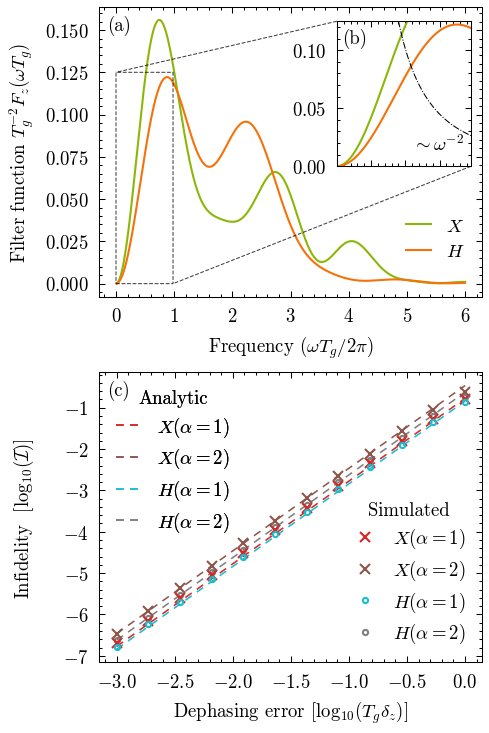

In [16]:
fig

In [17]:
for key in plot_dict:

    print(f'Gate: {key}')
    print('Superpropagator')
    superprop = plot_dict[key]['pulse_sequence'].total_propagator_liouville[1:,1:]
    print(superprop)
    print('Adjoint representation')
    adj = gate_dict[key].get_control_dict()['adj_curve']
    print(adj)
    print('------------')
    assert np.allclose(superprop, adj, atol=1e-3)

Gate: hadamard_step50000
Superpropagator
[[-1.40441080e-06 -2.46826143e-04  9.99999970e-01]
 [-2.44365641e-04 -9.99999940e-01 -2.46826479e-04]
 [ 9.99999970e-01 -2.44365980e-04  1.34409488e-06]]
Adjoint representation
[[ 1.67874177e-12 -9.34138309e-07  1.00000000e+00]
 [ 2.67432001e-13 -1.00000000e+00 -9.34138309e-07]
 [ 1.00000000e+00  2.67418312e-13 -1.67885555e-12]]
------------
Gate: xgate_step50000
Superpropagator
[[ 9.99999978e-01  2.09031746e-04  6.26333729e-07]
 [ 2.09031748e-04 -9.99999978e-01 -3.07693634e-06]
 [ 6.25690538e-07  3.07706720e-06 -1.00000000e+00]]
Adjoint representation
[[ 1.00000000e+00  8.27206829e-07 -4.28815751e-18]
 [ 8.27206829e-07 -1.00000000e+00  1.63462541e-17]
 [-7.44877080e-17  7.47034654e-18 -1.00000000e+00]]
------------


In [18]:
infid_dict

{'xgate_step50000': {1: {'simulated': np.float64(0.1607364000662187),
   'analytic': np.float64(0.16790879439262638),
   'cfi': nan},
  2: {'simulated': np.float64(0.2335516396128367),
   'analytic': np.float64(0.34378960733261493),
   'cfi': Array(0.3440441, dtype=float64)}},
 'hadamard_step50000': {1: {'simulated': np.float64(0.14011809514959708),
   'analytic': np.float64(0.1443764070294681),
   'cfi': nan},
  2: {'simulated': np.float64(0.1855127358449069),
   'analytic': np.float64(0.23727406526956804),
   'cfi': Array(0.23743216, dtype=float64)}}}

In [19]:
for gate in infid_dict:
    for alpha in infid_dict[gate]:
        for result_type in infid_dict[gate][alpha]:
            infid_val = infid_dict[gate][alpha][result_type] 
            infid_dict[gate][alpha][result_type] = np.round(infid_val,6)

In [20]:
infid_dict

{'xgate_step50000': {1: {'simulated': np.float64(0.160736),
   'analytic': np.float64(0.167909),
   'cfi': np.float64(nan)},
  2: {'simulated': np.float64(0.233552),
   'analytic': np.float64(0.34379),
   'cfi': Array(0.344044, dtype=float64)}},
 'hadamard_step50000': {1: {'simulated': np.float64(0.140118),
   'analytic': np.float64(0.144376),
   'cfi': np.float64(nan)},
  2: {'simulated': np.float64(0.185513),
   'analytic': np.float64(0.237274),
   'cfi': Array(0.237432, dtype=float64)}}}

In [21]:
pd.DataFrame(infid_dict['xgate_step50000'])

,1,2
simulated,0.160736,0.233552
analytic,0.167909,0.34379
cfi,NaN,0.34404399999999996


In [22]:
pd.DataFrame(infid_dict['hadamard_step50000'])

,1,2
simulated,0.140118,0.185513
analytic,0.144376,0.237274
cfi,NaN,0.23743199999999998


In [23]:
infid_dict['xgate_step50000'][2]['cfi'] - infid_dict['xgate_step50000'][2]['analytic']

Array(0.000254, dtype=float64)

In [24]:
infid_dict['hadamard_step50000'][2]['cfi'] - infid_dict['hadamard_step50000'][2]['analytic']

Array(0.000158, dtype=float64)

In [25]:
gate_dict['xgate_step50000'].get_robustness_properties()

|       closed_test       : 	 0.0000e+00
|     curve_area_test     : 	 3.5879e-03
|    tantrix_area_test    : 	 1.1872e-04
|           CFI           : 	 5.2288e-02


In [26]:
gate_dict['hadamard_step50000'].get_robustness_properties()

|       closed_test       : 	 0.0000e+00
|     curve_area_test     : 	 4.6033e-03
|    tantrix_area_test    : 	 1.8541e-05
|           CFI           : 	 3.6085e-02
